In [1]:
%matplotlib inline
%load_ext watermark
%watermark -v -m -p numpy,scipy,pandas,matplotlib,seaborn,sklearn,pywt 

CPython 3.5.2
IPython 5.1.0

numpy 1.11.1
scipy 0.18.0
pandas 0.18.1
matplotlib 1.5.1
seaborn 0.7.1
sklearn 0.18
pywt 0.4.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)
system     : Darwin
release    : 16.1.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [32]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
# import seaborn as sns

from pandas import set_option
set_option("display.max_rows", 50)
pd.options.mode.chained_assignment = None
filename = 'data/training_data.pkl'
training_data = pd.read_pickle(filename)
training_data.describe()
# training_data.isnull().sum()
# training_data['Well Name'].unique()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,GR_cD_step_level_1,...,PE_cD_step_level_2,PE_cD_step_level_3,PE_cD_step_level_4,PE_cD_step_level_5,PE_cD_step_level_6,GR_entropy_foot5,ILD_log10_entropy_foot5,DeltaPHI_entropy_foot5,PHIND_entropy_foot5,PE_entropy_foot5
count,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,...,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000
mean,4.502520,2906.351092,65.248225,0.659125,4.412696,13.203811,-22003.113383,1.519078,0.523053,-0.198926,...,-21934.026972,-21934.026972,-21934.026972,-21934.026972,-21934.026972,0.803668,0.778121,0.869436,0.831015,0.546265
std,2.475018,133.443259,30.951925,0.252315,5.267093,7.119856,41434.948570,0.499696,0.287208,5.096861,...,41384.660580,41384.660580,41384.660580,41384.660580,41384.660580,0.727580,0.740063,0.719423,0.738078,0.684827
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,-99999.000000,1.000000,0.000000,-96.538551,...,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2820.750000,44.912000,0.497034,1.602000,8.512250,2.442500,1.000000,0.278000,-1.206098,...,-0.228628,-0.228628,-0.228628,-0.228628,-0.228628,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,2932.500000,65.125000,0.639000,4.300000,12.036000,3.300000,2.000000,0.528000,0.015539,...,-0.027043,-0.027043,-0.027043,-0.027043,-0.027043,0.918296,0.918296,0.918296,0.918296,0.000000
75%,6.000000,3006.500000,79.535000,0.821000,7.500000,16.057000,4.000000,2.000000,0.769000,1.140359,...,0.024787,0.024787,0.024787,0.024787,0.024787,1.584963,1.584963,1.584963,1.584963,1.584963
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000,41.034509,...,1.523253,1.523253,1.523253,1.523253,1.523253,1.584963,1.584963,1.584963,1.584963,1.584963


In [3]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data.replace(to_replace=np.nan, value=-99999.0, inplace=True)
training_data['FaciesLabels'].value_counts()

CSiS    946
FSiS    786
PS      692
WS      582
MS      296
SiSh    271
SS      268
BS      185
D       141
Name: FaciesLabels, dtype: int64

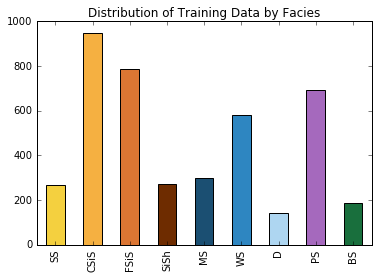

In [4]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels
sns.reset_orig()
facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')

## Test set
Remove a single well to use as a blind test later.

In [5]:
blind = training_data[training_data['Well Name'] == 'SHANKLE']
training_data = training_data[training_data['Well Name'] != 'SHANKLE']
training_data['Well Name'].unique()


array(['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A',
       'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY'], dtype=object)

In [6]:
y = training_data['Facies'].values

X = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1).values
# X.describe()

## Stratified K-Fold

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import StratifiedKFold
from sklearn import ensemble
from sklearn import svm
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=123, stratify=y)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
pipe_rf = make_pipeline(StandardScaler(), 
                        ensemble.RandomForestClassifier())

kfold = StratifiedKFold(y=y_train, 
                        n_folds=10,
                        random_state=1)

scores = []
for k, (train, test) in enumerate(kfold):
#     print(train.shape, test.shape)
    pipe_rf.fit(X_train[train], y_train[train])
    score = metrics.f1_score(y_train[test], pipe_rf.predict(X_train[test]), average='weighted')
    scores.append(score)
    print('Fold: %s, Class dist.: %s, f1-score: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

(2634, 42) (1129, 42) (2634,) (1129,)
Fold: 1, Class dist.: [  0 163 560 462 162 167 311  67 388  85], f1-score: 0.683
Fold: 2, Class dist.: [  0 163 560 462 163 167 311  67 388  85], f1-score: 0.651
Fold: 3, Class dist.: [  0 164 560 462 163 167 311  67 389  85], f1-score: 0.709
Fold: 4, Class dist.: [  0 164 561 462 163 167 311  67 389  85], f1-score: 0.741
Fold: 5, Class dist.: [  0 164 561 463 163 167 311  67 389  85], f1-score: 0.720
Fold: 6, Class dist.: [  0 164 561 463 163 167 311  68 389  86], f1-score: 0.673
Fold: 7, Class dist.: [  0 164 561 463 163 168 312  68 389  86], f1-score: 0.711
Fold: 8, Class dist.: [  0 164 561 463 163 168 312  68 389  86], f1-score: 0.733
Fold: 9, Class dist.: [  0 164 561 463 163 168 312  68 389  86], f1-score: 0.727
Fold: 10, Class dist.: [  0 164 561 463 163 168 312  68 389  86], f1-score: 0.729

CV accuracy: 0.708 +/- 0.028


In [8]:
from sklearn.grid_search import GridSearchCV


param_grid = {'randomforestclassifier__n_estimators': [10, 100, 1000],
              'randomforestclassifier__criterion'}

gs = GridSearchCV(estimator=pipe_rf, 
                  param_grid=param_grid, 
                  scoring='f1_weighted', 
                  cv=10,
                  n_jobs=1,
                  refit=True)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

/Users/lorenzoperozzi/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


0.7572888263393361
{'randomforestclassifier__n_estimators': 1000}


## Split into training and test set

Now we extract just the feature variables we need to perform the classification.  The predictor variables are the five wireline values and two geologic constraining variables. We also get a vector of the facies labels that correspond to each feature vector.

In [9]:
X_train = training_data.drop(['Formation', 'Well Name','Facies','FaciesLabels'], axis=1).values
y_train = training_data['Facies'].values
X_test = blind.drop(['Formation', 'Well Name','Facies','FaciesLabels'], axis=1).values
y_test = blind['Facies'].values

# from sklearn.preprocessing import StandardScaler
# X_scaler = StandardScaler()
# X_train = X_scaler.fit_transform(X_train)
# X_test = X_scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
# feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
# feature_vectors.describe()

(3763, 43)
(404, 43)
(3763,)
(404,)


In [10]:
clf = ensemble.RandomForestClassifier(n_estimators=1000, criterion="mae")
clf.fit(X_train, y_train)
print('****Results****\n')
predicted_labels = clf.predict(X_test)
f1 = metrics.f1_score(y_test, predicted_labels, average='weighted')
print("F1 score: {:.4%}".format(f1))

****Results****

F1 score: 45.1621%


/Users/lorenzoperozzi/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [83]:
training_data = pd.read_pickle('data/training_data.pkl')
training_data.drop_duplicates(inplace=True)
# training_data = pd.read_pickle('data/training_data_raw.pkl')
# training_data = pd.read_pickle('data/training_data_CannedGeo.pkl')

# PE_mask = training_data['PE'].notnull().values
# training_data = training_data[PE_mask]
training_data['PHINDxPE'] = training_data['PHIND']*training_data['PE']
training_data.describe()


,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,GR_cD_step_level_1,...,PHIND_cD_step_level_3,PE_cD_step_level_1,PE_cD_step_level_2,PE_cD_step_level_3,GR_entropy_foot10,ILD_log10_entropy_foot10,DeltaPHI_entropy_foot10,PHIND_entropy_foot10,PE_entropy_foot10,PHINDxPE
count,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,...,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4151.000000,4.151000e+03
mean,4.502048,2906.778126,64.938671,0.659477,4.404699,13.203233,-22087.939466,1.518429,0.522082,-0.149963,...,-0.022784,-22018.571435,-22018.571435,-22018.571435,0.803226,0.779793,0.870575,0.832670,0.545273,-2.696186e+05
std,2.474337,133.330124,30.295980,0.252675,5.274641,7.131810,41492.164833,0.499720,0.286767,4.924412,...,1.268329,41441.902455,41441.902455,41441.902455,0.728947,0.740483,0.720045,0.738475,0.685700,5.484185e+05
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,-99999.000000,1.000000,0.000000,-96.538551,...,-14.212082,-99999.000000,-99999.000000,-99999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.010970e+06
25%,2.000000,2821.500000,44.740000,0.497034,1.600000,8.500000,2.423000,1.000000,0.277000,-1.202735,...,-0.272629,-0.231496,-0.231496,-0.231496,0.000000,0.000000,0.000000,0.000000,0.000000,1.988060e+01
50%,4.000000,2932.500000,65.000000,0.639000,4.300000,12.030000,3.300000,2.000000,0.528000,0.013825,...,-0.001953,-0.027656,-0.027656,-0.027656,0.918296,0.918296,0.918296,0.918296,0.000000,3.731000e+01
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.057000,4.000000,2.000000,0.769000,1.162370,...,0.280288,0.025482,0.025482,0.025482,1.584963,1.584963,1.584963,1.584963,1.584963,5.148430e+01
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000,41.034509,...,22.766611,1.523253,1.523253,1.523253,1.584963,1.584963,1.584963,1.584963,1.584963,1.393473e+02


In [84]:
#Create a set of unique well names
from sklearn import preprocessing

names = list(set(training_data["Well Name"]))
target_names = ['SS','CsiS','FSiS', 'SiSh','MS','WS','D','PS','BS']
#Create a dicitionary of the well datasets, continued from original contest notebook 
#But perform dropping for each well individually
#Maybe not necessary.

well_datas = {}
for name in names:
    well = training_data[training_data["Well Name"]==name] 
    well_labels = well['Facies'].values.astype(np.int64)
    well = well.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1).values
    well_datas[name] = [well, well_labels]
    
    
X_data = {}
y_data = {}
for name, (data, labels) in well_datas.items():
    y_data[name] = np.array(labels, dtype=np.int64)
    X_data[name] = np.array(data, dtype=np.float32)

training_sets = []
test_sets = []

for i in range(len(names)):
    X_train = []
    y_train = []

    X_test = []
    y_test = []

    for name, data in X_data.items():
        if name is not names[i]:
            for row in data:
                X_train.append(row)
        else:
            for row in data:
                X_test.append(row)

    for name, labels in y_data.items():
        if name is not names[i]:
            for val in labels:
                y_train.append(val)
        else:
            for val in labels:
                y_test.append(val)

    X_train = np.array(X_train, dtype=np.float32)
    y_train = np.array(y_train, dtype=np.int64).reshape(len(y_train), 1)
    y_train = y_train.ravel()
    
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)


    X_test = np.array(X_test, dtype=np.float32)
    X_test = scaler.transform(X_test)

    y_test = np.array(y_test, dtype=np.int32)
    training_sets.append([X_train, y_train, X_test, y_test])
    
#Use as follows:
scores = []
for i, (X_train, y_train, X_test, y_test) in enumerate(training_sets):
    clf = ensemble.RandomForestClassifier(n_estimators=1000, max_features='auto')
#     clf = svm.LinearSVC(class_weight='balanced', tol=1e-03, random_state=42, C=10)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    #Scoring
    score = metrics.f1_score(y_test, y_pred, average='weighted')
    scores.append(score)
    cm = metrics.confusion_matrix(y_test,y_pred)
    print('********')
    print('Blind well is {0:10}, F1 score : {1:.4%}'.format(names[i],score))
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    print(metrics.classification_report(y_test,y_pred, target_names=target_names))
    print(cm)
    pass
print("="*30)
print("="*30)
print('Average  F1-score is {:.4%}'.format(np.mean(scores)))

/Users/lorenzoperozzi/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lorenzoperozzi/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


********
Blind well is KIMZEY A  , F1 score : 46.9443%
(3712, 28) (3712,) (439, 28) (439,)
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         9
          2       0.65      0.87      0.75        85
          3       0.71      0.54      0.62        74
          4       0.62      0.67      0.64        43
          5       0.00      0.00      0.00        53
          6       0.21      0.33      0.26        51
          7       1.00      0.04      0.07        27
          8       0.50      0.77      0.60        90
          9       0.00      0.00      0.00         7

avg / total       0.50      0.52      0.47       439

[[ 0  5  4  0  0  0  0  0  0]
 [ 0 74 11  0  0  0  0  0  0]
 [ 0 34 40  0  0  0  0  0  0]
 [ 0  0  0 29  1 11  0  2  0]
 [ 0  0  0  3  0 32  0 18  0]
 [ 0  0  1  5  1 17  0 27  0]
 [ 0  0  0  8  0  2  1 16  0]
 [ 0  0  0  2  0 19  0 69  0]
 [ 0  0  0  0  0  0  0  7  0]]


/Users/lorenzoperozzi/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/lorenzoperozzi/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


********
Blind well is LUKE G U  , F1 score : 67.2495%
(3690, 28) (3690,) (461, 28) (461,)
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         0
          2       0.63      0.74      0.68       117
          3       0.82      0.55      0.66       129
          4       0.78      0.83      0.81        35
          5       0.00      0.00      0.00         2
          6       0.72      0.67      0.69        84
          7       0.89      0.40      0.55        20
          8       0.61      0.69      0.65        74
          9       0.00      0.00      0.00         0

avg / total       0.72      0.66      0.67       461

[[ 0  0  0  0  0  0  0  0  0]
 [16 87 14  0  0  0  0  0  0]
 [ 1 50 71  0  0  0  0  7  0]
 [ 0  0  1 29  1  4  0  0  0]
 [ 0  0  0  0  0  1  0  1  0]
 [ 0  1  0  5  9 56  0 13  0]
 [ 0  0  0  0  0  0  8 11  1]
 [ 0  0  1  3  1 17  1 51  0]
 [ 0  0  0  0  0  0  0  0  0]]


/Users/lorenzoperozzi/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/lorenzoperozzi/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


********
Blind well is NOLAN     , F1 score : 50.8782%
(3736, 28) (3736,) (415, 28) (415,)
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         4
          2       0.74      0.66      0.70       118
          3       0.58      0.63      0.61        68
          4       0.67      0.14      0.24        28
          5       0.00      0.00      0.00        47
          6       0.16      0.40      0.23        30
          7       0.25      0.50      0.33         4
          8       0.68      0.58      0.63       116
          9       0.00      0.00      0.00         0

avg / total       0.56      0.50      0.51       415

[[ 0  4  0  0  0  0  0  0  0]
 [11 78 28  0  0  0  0  1  0]
 [ 4 18 43  0  0  2  0  1  0]
 [ 1  0  0  4  3 17  1  2  0]
 [ 0  3  0  0  0 28  2 11  3]
 [ 1  0  0  0  0 12  1 15  1]
 [ 0  0  0  1  0  0  2  1  0]
 [ 0  2  3  1  0 16  2 67 25]
 [ 0  0  0  0  0  0  0  0  0]]


/Users/lorenzoperozzi/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/lorenzoperozzi/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


********
Blind well is SHANKLE   , F1 score : 47.1557%
(3702, 28) (3702,) (449, 28) (449,)
             precision    recall  f1-score   support

          1       0.27      0.04      0.08        89
          2       0.34      0.72      0.46        89
          3       0.79      0.61      0.69       117
          4       0.07      0.14      0.09         7
          5       0.00      0.00      0.00        19
          6       0.69      0.69      0.69        71
          7       0.82      0.53      0.64        17
          8       0.51      0.68      0.58        40
          9       0.00      0.00      0.00         0

avg / total       0.51      0.50      0.47       449

[[ 4 80  5  0  0  0  0  0  0]
 [11 64 14  0  0  0  0  0  0]
 [ 0 46 71  0  0  0  0  0  0]
 [ 0  0  0  1  0  5  0  1  0]
 [ 0  0  0 11  0  5  1  2  0]
 [ 0  0  0  3  3 49  0 16  0]
 [ 0  0  0  0  0  1  9  7  0]
 [ 0  0  0  0  0 11  1 27  1]
 [ 0  0  0  0  0  0  0  0  0]]


/Users/lorenzoperozzi/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lorenzoperozzi/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


********
Blind well is ALEXANDER D, F1 score : 59.1507%
(3685, 28) (3685,) (466, 28) (466,)
             precision    recall  f1-score   support

          2       0.86      0.72      0.78       117
          3       0.70      0.85      0.77        91
          4       0.61      0.84      0.70        44
          5       0.29      0.31      0.30        26
          6       0.42      0.22      0.29        69
          7       0.20      0.50      0.28        16
          8       0.54      0.51      0.53        98
          9       0.00      0.00      0.00         5

avg / total       0.61      0.60      0.59       466

[[84 33  0  0  0  0  0  0]
 [14 77  0  0  0  0  0  0]
 [ 0  0 37  2  2  2  1  0]
 [ 0  0  2  8  5  1 10  0]
 [ 0  0 12 13 15  5 24  0]
 [ 0  0  0  0  1  8  7  0]
 [ 0  0  7  5 13 23 50  0]
 [ 0  0  3  0  0  2  0  0]]
********
Blind well is CROSS H CATTLE, F1 score : 33.8103%
(3648, 28) (3648,) (503, 28) (503,)
             precision    recall  f1-score   support

         

/Users/lorenzoperozzi/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/lorenzoperozzi/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


********
Blind well is NEWBY     , F1 score : 52.2772%
(3688, 28) (3688,) (463, 28) (463,)
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         0
          2       0.63      0.67      0.65        98
          3       0.58      0.50      0.54        80
          4       0.90      0.66      0.76        58
          5       0.07      0.04      0.05        28
          6       0.52      0.45      0.48        96
          7       0.55      0.38      0.44        16
          8       0.36      0.82      0.50        56
          9       1.00      0.16      0.28        31

avg / total       0.59      0.53      0.52       463

[[ 0  0  0  0  0  0  0  0  0]
 [ 5 66 27  0  0  0  0  0  0]
 [ 1 39 40  0  0  0  0  0  0]
 [ 0  0  0 38  0 19  0  1  0]
 [ 0  0  2  3  1  7  4 11  0]
 [ 0  0  0  1 11 43  0 41  0]
 [ 0  0  0  0  0  2  6  8  0]
 [ 0  0  0  0  2  7  1 46  0]
 [ 0  0  0  0  0  4  0 22  5]]


/Users/lorenzoperozzi/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/lorenzoperozzi/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


********
Blind well is Recruit F9, F1 score : 63.2479%
(4071, 28) (4071,) (80, 28) (80,)
             precision    recall  f1-score   support

          4       0.00      0.00      0.00         0
          6       0.00      0.00      0.00         0
          7       0.00      0.00      0.00         0
          8       0.00      0.00      0.00         0
          9       1.00      0.46      0.63        80

avg / total       1.00      0.46      0.63        80

[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 3 11  2 27 37]]


/Users/lorenzoperozzi/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/lorenzoperozzi/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


********
Blind well is SHRIMPLIN , F1 score : 55.6179%
(3680, 28) (3680,) (471, 28) (471,)
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         0
          2       0.68      0.75      0.72       118
          3       0.81      0.65      0.72       123
          4       0.61      0.61      0.61        18
          5       0.00      0.00      0.00        63
          6       0.39      0.60      0.47        63
          7       0.00      0.00      0.00         5
          8       0.53      0.83      0.65        69
          9       0.50      0.17      0.25        12

avg / total       0.55      0.59      0.56       471

[[ 0  0  0  0  0  0  0  0  0]
 [10 89 19  0  0  0  0  0  0]
 [ 2 41 80  0  0  0  0  0  0]
 [ 0  0  0 11  0  3  0  4  0]
 [ 0  0  0  5  0 45  0 13  0]
 [ 0  0  0  2  0 38  2 20  1]
 [ 0  0  0  0  0  0  0  5  0]
 [ 0  0  0  0  1  9  1 57  1]
 [ 0  0  0  0  0  2  0  8  2]]
********
Blind well is CHURCHMAN BIBLE, F1 score : 4

/Users/lorenzoperozzi/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lorenzoperozzi/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [50]:
names

['LUKE G U',
 'NOLAN',
 'CROSS H CATTLE',
 'NEWBY',
 'Recruit F9',
 'SHRIMPLIN',
 'CHURCHMAN BIBLE']

In [42]:
len(training_data[training_data['Well Name']=='NOLAN'])

415

## Comparing classifier

In [11]:
# from sklearn import cross_validation
# from sklearn import tree
# from sklearn import svm
# from sklearn import ensemble
# from sklearn import neighbors
# from sklearn import linear_model
# from sklearn import metrics
# from sklearn import preprocessing
# from xgboost import XGBClassifier

# from sklearn.metrics import confusion_matrix
# from classification_utilities import display_cm, display_adj_cm
# from sklearn.metrics import classification_report

# def accuracy(conf):
#     total_correct = 0.
#     nb_classes = conf.shape[0]
#     for i in np.arange(0,nb_classes):
#         total_correct += conf[i][i]
#     acc = total_correct/sum(sum(conf))
#     return acc

# adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

# def accuracy_adjacent(conf, adjacent_facies):
#     nb_classes = conf.shape[0]
#     total_correct = 0.
#     for i in np.arange(0,nb_classes):
#         total_correct += conf[i][i]
#         for j in adjacent_facies[i]:
#             total_correct += conf[i][j]
#     return total_correct / sum(sum(conf))

In [12]:
# classifiers = [
#     svm.LinearSVC(class_weight='balanced', tol=1e-03, random_state=42, C=10),
#     ensemble.RandomForestClassifier(n_estimators=1000),
#     ensemble.GradientBoostingClassifier(min_samples_split=1),
#     ensemble.BaggingClassifier(),
#     XGBClassifier()]

In [13]:
# # Logging for Visual Comparison
# log_cols=["Classifier", "Accuracy", "Precision", "Recall", "F1-score"]
# log = pd.DataFrame(columns=log_cols)

# for clf in classifiers:
#     clf.fit(X_train, y_train)
#     name = clf.__class__.__name__
    
#     print("="*30)
#     print(name)
    
#     print('****Results****\n')
#     predicted_labels = clf.predict(X_test)
    
#     accuracy = metrics.accuracy_score(y_test, predicted_labels)
#     print("Accuracy: {:.4%}".format(accuracy))
# #     conf = confusion_matrix(y_test, predicted_labels)

# #     print('Optimized facies classification accuracy = %.2f' % accuracy(conf))
# #     print('Optimized adjacent facies classification accuracy = %.2f\n' % accuracy_adjacent(conf, adjacent_facies))
    
# #     display_adj_cm(conf, facies_labels, adjacent_facies,display_metrics=True, hide_zeros=True)
    
    
    

#     precision = metrics.precision_score(y_test, predicted_labels, average='weighted')
#     print("Precision: {:.4%}".format(precision))
    
#     recall = metrics.recall_score(y_test, predicted_labels, average='weighted')
#     print("Recall: {:.4%}".format(recall))
    
#     f1 = metrics.f1_score(y_test, predicted_labels, average='weighted')
#     print("F1 score: {:.4%}".format(f1))
    
#     print(metrics.classification_report(y_test, predicted_labels, target_names=facies_labels))
       
#     log_entry = pd.DataFrame([[name, accuracy*100, precision*100, recall*100, f1*100]], columns=log_cols)
#     log = log.append(log_entry)
    
# print("="*30)